In [33]:
!pip install tensorflow_addons

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%precision %.2f
%tensorflow_version 2.x
import re
from sklearn.model_selection import train_test_split
from tensorflow.python.pywrap_tensorflow_internal import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf 
import tensorflow_addons as tfa
from keras.layers import Embedding

from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout,concatenate
from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from keras.models import Model
from keras import regularizers

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

In [35]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/DATA586/anomaly-dection-project/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/DATA586/anomaly-dection-project


In [36]:
df = pd.read_csv('BGL_cleaned.csv')

In [38]:
anomaly = [0]*len(df['info'])
normal = [0]*len(df['info'])

for idx, i in enumerate(df['label']):
    if i == 'Anomaly':
      anomaly[idx] = 1
    else:
      normal[idx] = 1

df['anomaly'] = anomaly
df['normal'] = normal

del(anomaly)
del(normal)

In [39]:
#split 20% of train as validation set
X = df['info']
y = df.iloc[:,7:]

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, random_state=123)

In [40]:
%cd data/

/content/drive/MyDrive/Colab Notebooks/DATA586/anomaly-dection-project/data


In [41]:
 word_vectors = dict()

# load the whole embedding into memory
f = open('glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [42]:
# Set Maximum number of words to be embedded
NUM_WORDS = 20000

# Define/Load Tokenize text function
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')

# Fit the function on the text
tokenizer.fit_on_texts(X_train)

# Count number of unique tokens
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1082 unique tokens.


In [43]:
# Convert train and val to sequence
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_validation = tokenizer.texts_to_sequences(X_validation)

In [44]:
# Limit size of train/val to 50 and pad the sequence
X_train = pad_sequences(sequences_train,maxlen=50)
X_validation = pad_sequences(sequences_validation,maxlen=X_train.shape[1])

# Convert target to array
y_train = np.asarray(y_train)
y_validation = np.asarray(y_validation)

# Printing shape
print('Shape of X train and X validation tensor:', X_train.shape,X_validation.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_validation.shape)


Shape of X train and X validation tensor: (37984, 50) (9496, 50)
Shape of label train and validation tensor: (37984, 2) (9496, 2)


In [45]:
EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


In [46]:
del(word_vectors)

In [47]:
# Dfine Embedding function using the embedding_matrix
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)
del(embedding_matrix)

In [48]:
sequence_length = X_train.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=2, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

In [49]:
model.compile(optimizer=Adam(0.001), 
              metrics=['accuracy', 'Precision', 'Recall',tfa.metrics.F1Score(num_classes=2,average='macro')], 
              loss = 'binary_crossentropy')
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_validation, y_validation), batch_size=100)

Epoch 1/10
380/380 [==============================] - 93s 241ms/step - loss: 0.4031 - accuracy: 0.9272 - precision: 0.9294 - recall: 0.9270 - f1_score: 0.4846 - val_loss: 0.3043 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271 - val_f1_score: 0.4811
Epoch 2/10
380/380 [==============================] - 89s 233ms/step - loss: 0.2864 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - f1_score: 0.4817 - val_loss: 0.2835 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271 - val_f1_score: 0.4811
Epoch 3/10
380/380 [==============================] - 88s 233ms/step - loss: 0.2742 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - f1_score: 0.4817 - val_loss: 0.2764 - val_accuracy: 0.9271 - val_precision: 0.9271 - val_recall: 0.9271 - val_f1_score: 0.4811
Epoch 4/10
380/380 [==============================] - 98s 258ms/step - loss: 0.2689 - accuracy: 0.9294 - precision: 0.9294 - recall: 0.9294 - f1_score: 0.4817 - val_loss: 0.2731 - val_accuracy:

In [50]:
test_loss, test_acc, test_preci, test_recall, test_f1 = model.evaluate(X_validation, y_validation, verbose = 2)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

297/297 - 4s - loss: 0.2651 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271 - f1_score: 0.4811 - 4s/epoch - 13ms/step
Test Loss: 0.2650999128818512
Test Accuracy: 0.9271271824836731


In [51]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.00, 0.41)

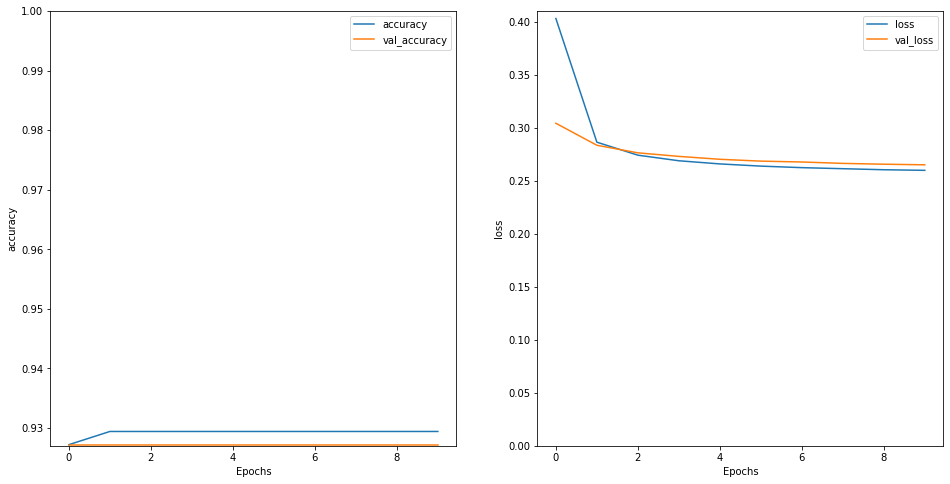

In [52]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)